In [2]:
import pandas as pd
import os
import requests
import json

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [4]:
from preprocessing_utils import preprocess_NVD_data

In [5]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Download the EPSS data from https://www.first.org/epss/data_stats into `data` folder

### <font color='blue'><b><i>TODO</i></b></font>:
- in the following cell, replace `epss_scores-2025-09-30.csv.gz` with the correct updated file (`epss_scores-2025-10-01.csv.gz`)

In [6]:
epss_current = pd.read_csv(os.path.join(data_path, 'epss_scores-2025-10-07.csv.gz'), compression='gzip', header=1)
epss_current # a Python statement with a variable name at the end of a cell will display its contents below


,cve,epss,percentile
0,CVE-1999-0001,0.01076,0.77049
1,CVE-1999-0002,0.15339,0.94379
2,CVE-1999-0003,0.90362,0.99578
3,CVE-1999-0004,0.03215,0.86549
4,CVE-1999-0005,0.25334,0.96003
...,...,...,...
297004,CVE-2025-9994,0.00063,0.19968
297005,CVE-2025-9996,0.00179,0.39863
297006,CVE-2025-9997,0.00182,0.40222
297007,CVE-2025-9998,0.00025,0.05498


# NVD data

In [7]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z' # Do NOT change these dates
date_end_NVD   = '2025-10-01T00:00:00.000Z' # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1 

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


In [8]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus']!='Reserved') & (df['cve.vulnStatus']!='Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id", right_on="cve", how="left")

In [9]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)
    
# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

- display some examples (e.g., the first two CVE records)

In [10]:
df.head(2).T
# T for transpose

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- show a bar plot with the daily volume of published CVEs

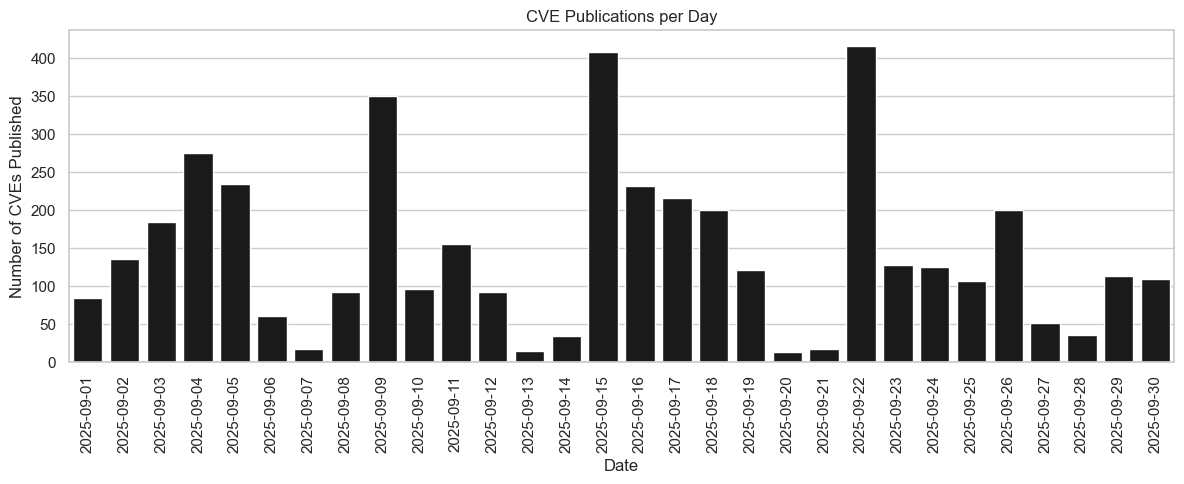

In [ ]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.barplot(x=published_counts.index, y=published_counts.values, color="k" )
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

In [ ]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- print the description of the last ten published vulnerabilities

In [ ]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)


----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV? 
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

## Percentage of CVEs with CVSS Score

Let's analyze what percentage of the CVEs in our dataset have been assigned a CVSS score, which will help us understand the coverage of vulnerability severity assessment.

In [11]:
# Calculate the percentage of CVEs with CVSS scores
total_cves = len(df)
cves_with_cvss = df['cvss_baseScore'].notna().sum()
percentage = (cves_with_cvss / total_cves) * 100

print(f"Total number of CVEs: {total_cves}")
print(f"CVEs with CVSS scores: {cves_with_cvss}")
print(f"Percentage of CVEs with CVSS scores: {percentage:.2f}%")

Total number of CVEs: 4325
CVEs with CVSS scores: 3344
Percentage of CVEs with CVSS scores: 77.32%


## CVSS Base Score Analysis

Let's examine the distribution and descriptive statistics of the CVSS base scores to understand the severity levels of the vulnerabilities in our dataset.

CVSS Base Score Statistics:
count    3344.000000
mean        6.906041
std         1.804292
min         2.200000
25%         5.400000
50%         6.500000
75%         8.200000
max        10.000000
Name: cvss_baseScore, dtype: float64


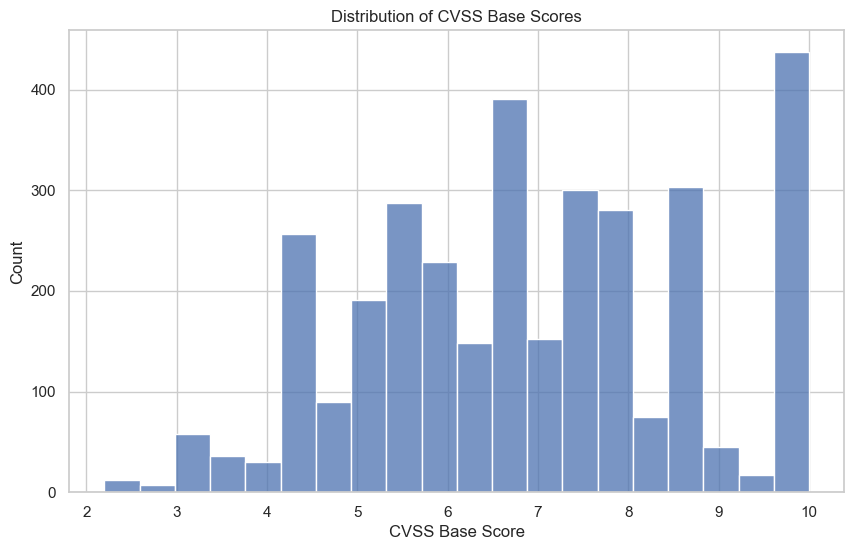

In [12]:
# Analyze CVSS base score distribution
cvss_stats = df['cvss_baseScore'].describe()
print("CVSS Base Score Statistics:")
print(cvss_stats)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='cvss_baseScore', bins=20)
plt.title('Distribution of CVSS Base Scores')
plt.xlabel('CVSS Base Score')
plt.ylabel('Count')
plt.show()

## EPSS Distribution Analysis

Let's analyze the distribution of EPSS scores to understand the likelihood of vulnerabilities being exploited in our dataset.

EPSS Score Statistics:
count    4325.000000
mean        0.001499
std         0.017347
min         0.000020
25%         0.000240
50%         0.000330
75%         0.000490
max         0.824070
Name: epss, dtype: float64


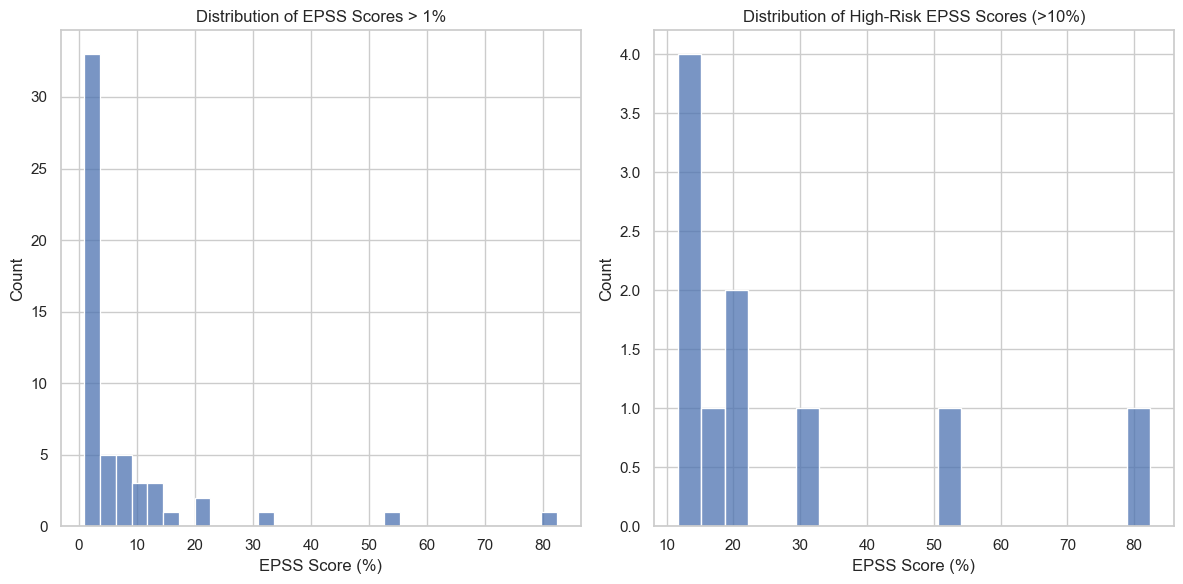


Risk Distribution Summary:
Total Vulnerabilities: 4325
High Risk (EPSS > 10%): 10 (0.23%)
Medium Risk (1% < EPSS ≤ 10%): 45 (1.04%)
Low Risk (EPSS ≤ 1%): 4270 (98.73%)


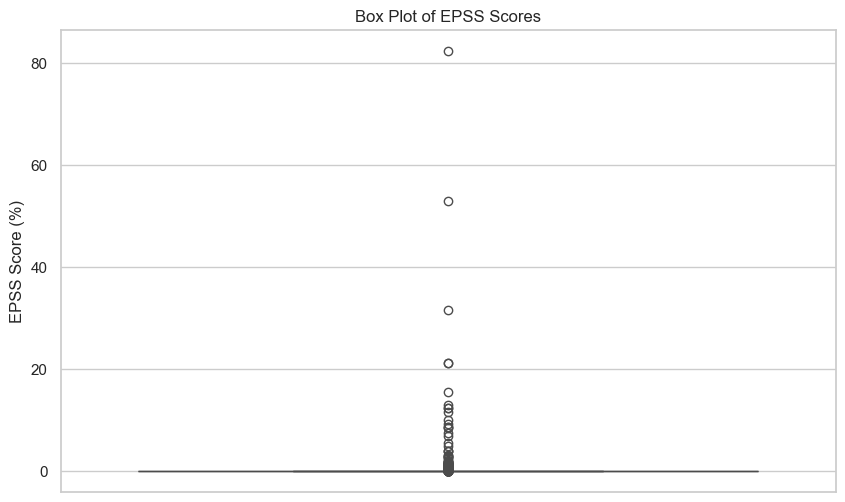

In [13]:
# Analyze EPSS distribution
epss_stats = df['epss'].describe()
print("EPSS Score Statistics:")
print(epss_stats)

# Convert EPSS to percentage for better readability
df['epss_percentage'] = df['epss'] * 100

# Create more informative plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Plot for EPSS > 1%
sns.histplot(data=df[df['epss_percentage'] > 1], x='epss_percentage', bins=30)
plt.title('Distribution of EPSS Scores > 1%')
plt.xlabel('EPSS Score (%)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
# Plot focusing on high-risk vulnerabilities
sns.histplot(data=df[df['epss_percentage'] > 10], x='epss_percentage', bins=20)
plt.title('Distribution of High-Risk EPSS Scores (>10%)')
plt.xlabel('EPSS Score (%)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Add summary statistics
total_vulns = len(df)
high_risk = len(df[df['epss_percentage'] > 10])
medium_risk = len(df[(df['epss_percentage'] <= 10) & (df['epss_percentage'] > 1)])
low_risk = len(df[df['epss_percentage'] <= 1])

print("\nRisk Distribution Summary:")
print(f"Total Vulnerabilities: {total_vulns}")
print(f"High Risk (EPSS > 10%): {high_risk} ({(high_risk/total_vulns)*100:.2f}%)")
print(f"Medium Risk (1% < EPSS ≤ 10%): {medium_risk} ({(medium_risk/total_vulns)*100:.2f}%)")
print(f"Low Risk (EPSS ≤ 1%): {low_risk} ({(low_risk/total_vulns)*100:.2f}%)")

# Show box plot for better visualization of outliers
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['epss_percentage'])
plt.title('Box Plot of EPSS Scores')
plt.ylabel('EPSS Score (%)')
plt.show()

## CVSS vs EPSS Correlation

Let's create a scatter plot to visualize the relationship between CVSS base scores and EPSS scores to understand if there's any correlation between vulnerability severity and exploitation probability.

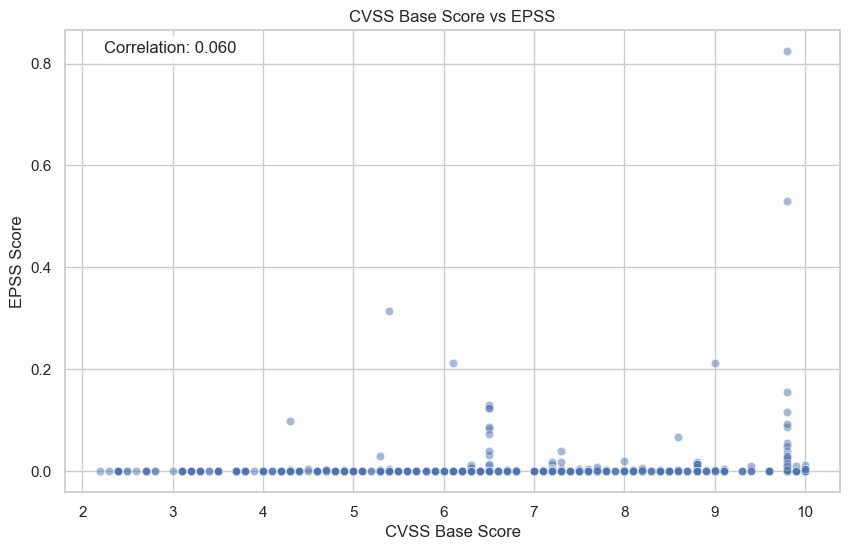

In [14]:
# Create scatter plot of CVSS vs EPSS
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, 
                x='cvss_baseScore',
                y='epss',
                alpha=0.5)
plt.title('CVSS Base Score vs EPSS')
plt.xlabel('CVSS Base Score')
plt.ylabel('EPSS Score')

# Calculate correlation
correlation = df['cvss_baseScore'].corr(df['epss'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

## Additional Analysis

Let's explore additional insights including CISA KEV vulnerabilities, most frequent vendors, and common CWEs to better understand the vulnerability landscape.

In [27]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


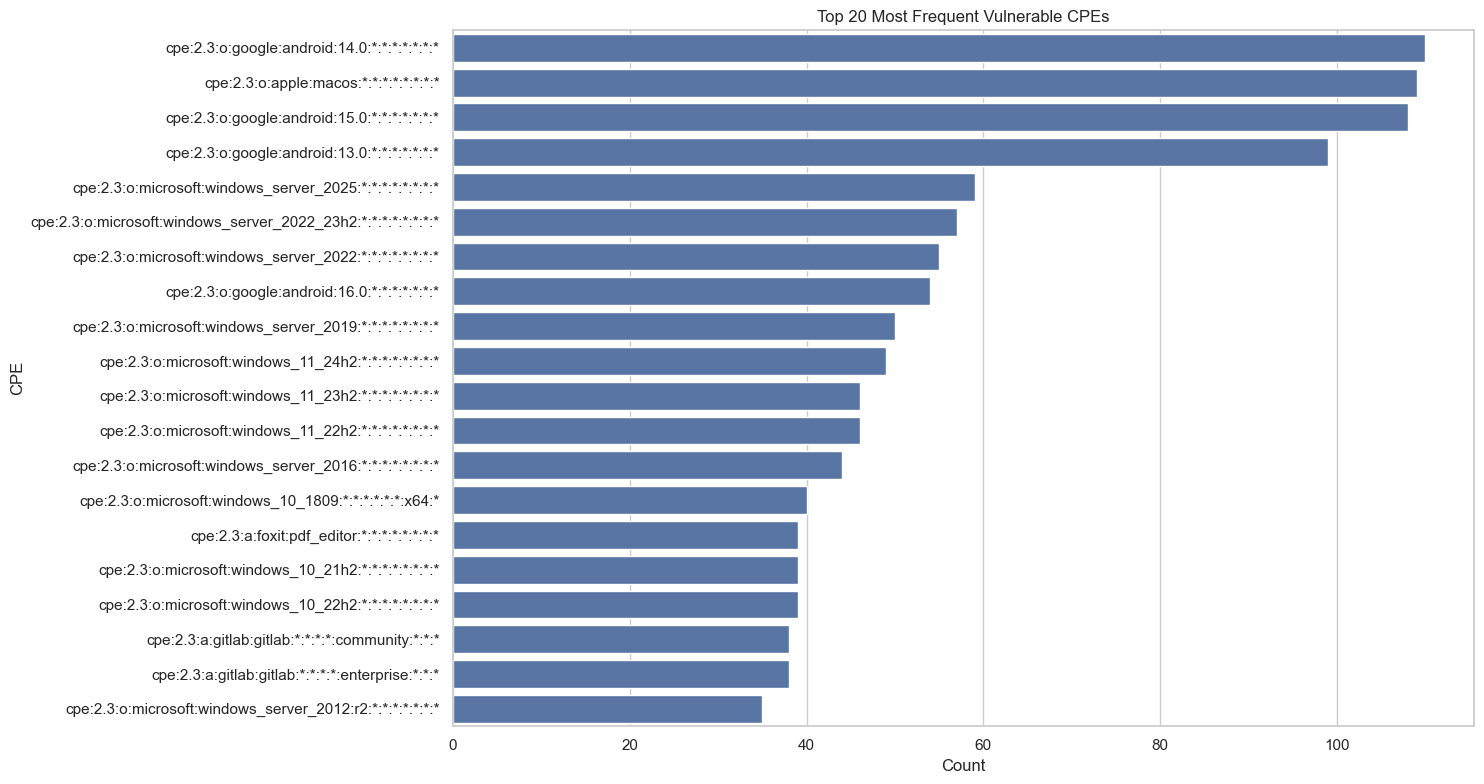


Top 20 Most Frequent CPEs and their counts:
vulnerable_cpes
cpe:2.3:o:google:android:14.0:*:*:*:*:*:*:*                     110
cpe:2.3:o:apple:macos:*:*:*:*:*:*:*:*                           109
cpe:2.3:o:google:android:15.0:*:*:*:*:*:*:*                     108
cpe:2.3:o:google:android:13.0:*:*:*:*:*:*:*                      99
cpe:2.3:o:microsoft:windows_server_2025:*:*:*:*:*:*:*:*          59
cpe:2.3:o:microsoft:windows_server_2022_23h2:*:*:*:*:*:*:*:*     57
cpe:2.3:o:microsoft:windows_server_2022:*:*:*:*:*:*:*:*          55
cpe:2.3:o:google:android:16.0:*:*:*:*:*:*:*                      54
cpe:2.3:o:microsoft:windows_server_2019:*:*:*:*:*:*:*:*          50
cpe:2.3:o:microsoft:windows_11_24h2:*:*:*:*:*:*:*:*              49
cpe:2.3:o:microsoft:windows_11_23h2:*:*:*:*:*:*:*:*              46
cpe:2.3:o:microsoft:windows_11_22h2:*:*:*:*:*:*:*:*              46
cpe:2.3:o:microsoft:windows_server_2016:*:*:*:*:*:*:*:*          44
cpe:2.3:o:microsoft:windows_10_1809:*:*:*:*:*:*:x64:*  

KeyError: 'cwe'

<Figure size 1500x800 with 0 Axes>

In [26]:
# 1. Analyze vendor information from vulnerable_cpes
plt.figure(figsize=(15, 8))
# Extract and count top 20 vendors from vulnerable_cpes
vendors = df['vulnerable_cpes'].explode().value_counts().head(20)
sns.barplot(x=vendors.values, y=vendors.index)
plt.title('Top 20 Most Frequent Vulnerable CPEs')
plt.xlabel('Count')
plt.ylabel('CPE')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Frequent CPEs and their counts:")
print(vendors)

# 2. CWE Analysis
plt.figure(figsize=(15, 8))
# Get top 20 CWEs
cwe_counts = df['cwe'].explode().value_counts().head(20)
sns.barplot(x=cwe_counts.values, y=cwe_counts.index)
plt.title('Top 20 Most Frequent CWEs')
plt.xlabel('Count')
plt.ylabel('CWE')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Frequent CWEs and their counts:")
print(cwe_counts)

# 3. Additional Analysis: CWE Categories vs EPSS
plt.figure(figsize=(15, 8))
# Get top 10 CWEs and their average EPSS scores
top_10_cwes = df.explode('cwe').groupby('cwe')['epss'].agg(['mean', 'count']).sort_values('count', ascending=False).head(10)
sns.barplot(x=top_10_cwes['count'], y=top_10_cwes.index)
plt.title('Top 10 CWEs by Frequency with Average EPSS Score')
plt.xlabel('Count')
plt.ylabel('CWE')

# Add EPSS average annotations
for idx, row in enumerate(top_10_cwes.itertuples()):
    plt.text(row.count, idx, f' EPSS avg: {row.mean:.3f}', va='center')

plt.tight_layout()
plt.show()

# 4. Analysis of References and their correlation with EPSS
plt.figure(figsize=(12, 6))
# Calculate number of references per CVE
df['reference_count'] = df['references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.subplot(1, 2, 1)
# Distribution of reference counts
sns.histplot(data=df, x='reference_count', bins=30)
plt.title('Distribution of Reference Counts')
plt.xlabel('Number of References')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
# References vs EPSS correlation
sns.scatterplot(data=df, x='reference_count', y='epss', alpha=0.5)
plt.title('Reference Count vs EPSS Score')
plt.xlabel('Number of References')
plt.ylabel('EPSS Score')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total number of unique CWEs: {df['cwe'].explode().nunique()}")
print(f"Average number of references per CVE: {df['reference_count'].mean():.2f}")
print(f"Correlation between reference count and EPSS: {df['reference_count'].corr(df['epss']):.3f}")

# Print top CWEs with highest average EPSS scores (minimum 5 occurrences)
print("\nTop 10 CWEs by average EPSS score (minimum 5 vulnerabilities):")
cwe_epss = df.explode('cwe').groupby('cwe').agg({
    'epss': ['mean', 'count']
}).reset_index()
cwe_epss = cwe_epss[cwe_epss[('epss', 'count')] >= 5]
print(cwe_epss.sort_values(('epss', 'mean'), ascending=False).head(10))

# CVE selection


### <font color='blue'><b><i>TODO</i></b>
- Filter the CVEs with low EPSS (<1%)
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time


In [ ]:
nickname = 'template_submsission' # TODO: put your nickname here


# TODO: put your selected IDs here
selected = ['CVE-YYYY-XXXXX0',
            'CVE-YYYY-XXXXX1',
            'CVE-YYYY-XXXXX2',
            'CVE-YYYY-XXXXX3',
            'CVE-YYYY-XXXXX4',
            'CVE-YYYY-XXXXX5',
            'CVE-YYYY-XXXXX6',
            'CVE-YYYY-XXXXX7',
            'CVE-YYYY-XXXXX8',
            'CVE-YYYY-XXXXX9',
           ]            

df[df['cve.id'].isin(selected)].to_csv(os.path.join(data_path, f'{nickname}.csv'))            